# Analyze loyalty program automated decisions for retail

## Get insights in your retail automation operated with IBM Cloud Pak for Business Automation

This notebook shows the exploitation of a dataset of loyalty program decisions automated by IBM Cloud Pak for Business Automation to determine discounts and coupons. More precisely we applied <b>Automation Decision Services</b> to model a low code decision service and deploy it as a rest endpoint. From there we use a simulation microservice project called SimuLatte to generate analytical notebooks to get insights for the decision automation.

In this approach we dive into the automated decision dataset. For each decision we captured the request with all input parameters, the answer with all output parameters computed by the decision logic, and the trace. In the trace you find the list of the executed rules and potentialy ML models.

* [Installing librairies](#section0)
* [1 - Read the decision dataset](#section1)
* [2 - Measure business performances](#section2)
    * [2.1 Business metrics](#section_2_1)
    * [2.2 Business kpis](#section2_2)
* [3 - Business visualization](#section3)
    * [3.1 Offer distribution ](#section3_1)
    * [3.2 Distribution of offers by category  ](#section3_2)
    * [3.3 Distribution of product references in the orders  ](#section3_3)
* [4 - Go inside the decisions](#section4 )
    * [4.1 Representing the decision model coverage through a sandkey](#section4_1)
    * [4.2 Representing the decision model coverage through a sunburst](#section4_2)
    * [4.3 Tabular rule coverage](#section4_3)
    * [4.4 Rule coverage bargraph](#section4_4)
* [Conclusion](#section5)


## Importing librairies <a class="anchor" id="section0"></a>

In [1]:
from urllib.parse import urlencode
from urllib.request import Request, urlopen

from faker import Faker

from pathlib import Path 

import json
import random 
import datetime

import os
import sys

import requests

import pandas as pd 
import numpy as np

import tqdm

import uuid

from IPython.display import display, HTML


import plotly
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.express as px
init_notebook_mode(connected = True)

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import pgeocode

GOBAL VARIABLES

In [2]:
SIMULATTE_BASE_DIR = os.environ['SIMULATTE_BASE_DIR'] #"/Users/tiemokodembele/Documents/internShip/simulatte-public" 
SIMULATTE_ONLINE_HOSTNAME = os.environ['SIMULATTE_ONLINE_HOSTNAME'] 
SIMULATTE_ANALYTIC_HOSTNAME = os.environ['SIMULATTE_ANALYTIC_HOSTNAME']

DATASET GENERATION

In [3]:
serverDjangoEndpoint = f"http://{SIMULATTE_ANALYTIC_HOSTNAME}:8000/data/from-url/"
headers = {'Content-type': 'application/json'} 

############## DATA FROM REMOTE CSV FILE ################
def get_from_url(data_sink_filepath, size):

    fake = Faker()

    # Models
    customer = dict()
    request = dict()

    #Set list of values
    customer_status = ["Gold", "Silver", "Bronze", "Platinum"]
    products_dataset = pd.read_csv(f"{SIMULATTE_BASE_DIR}/data/ADS/loyaltyProgram/DatafinitiElectronicsProductsPricingData.csv")
    products_dataset = products_dataset[['name', 'prices.amountMax']].copy().rename(columns={'prices.amountMax': 'price'})          

    file = Path(data_sink_filepath)
    if file.exists():
        file = open(data_sink_filepath,"r+")
        file.truncate(0)
        file.close()

    for counter in range(0, size):
        order = []
        number_of_orders = random.randint(1, 11)
        for product in range(0, number_of_orders):
            item_order = dict()
            index = random.randint(0, len(products_dataset)-1)
            item_order["name"] = products_dataset._get_value(index, 'name')
            item_order["price"] = products_dataset._get_value(index, 'price')
            order.append(item_order)

        customer["name"] = fake.name()
        customer["status"] = random.choice(customer_status)
        customer["offers"] = []
        customer["totalAmount"] = random.randint(1000, 10000)
        customer["walletAmount"] = random.randint(0, 999)

        request["customer"] = customer
        request["order"] = order

        with open(data_sink_filepath, 'a') as file:
            file.write(json.dumps(request))
            file.write('\n')

size = 10
filesize = size
date_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
if(size>999): filesize = str(size)[:-3]+"K"
data_filepath = f"{SIMULATTE_BASE_DIR}/data/ADS/loyaltyProgram/ads-22.0.1-loyaltyprogram-requests-{date_time}-{filesize}.json"
get_from_url(data_filepath, size)

In [4]:
######## GET DATA #########
dataSourcePathADS = data_filepath

inputData = []
with open(dataSourcePathADS) as file:
    while (line := file.readline().rstrip()):
        inputData.append(json.loads(line))

data = pd.json_normalize(inputData, max_level=1)
data.head(5)

,order,customer.name,customer.status,customer.offers,customer.totalAmount,customer.walletAmount
0,[{'name': 'H6 Handy Recorder Kit with Resident...,Jeffery Ingram,Bronze,[],5117,903
1,[{'name': 'Pioneer 200W 4x6 Inch 3 Way 4 Ohms ...,Charles Ross,Silver,[],9425,594
2,[{'name': 'JBL Everest Elite 100 NXTGen Noise-...,Joseph Mccormick,Silver,[],2183,895
3,[{'name': 'Cooler Master - HAF X Ultimate Full...,Joseph Ryan,Silver,[],7946,236
4,[{'name': 'Seagate Backup Plus Ultra Slim 2TB ...,Michael Clark,Bronze,[],4680,370


CREATE SIMULATION 

In [5]:
datasinkFolderPath = f"{SIMULATTE_BASE_DIR}/data/ADS/loyaltyProgram"
createSimulationUrl = f"http://{SIMULATTE_ONLINE_HOSTNAME}:8080/v1/simulation/create"
adsEndpoint1 = "https://cpd-cp4a.apps.ads2201.cp.fyre.ibm.com/ads/runtime/api/v1/deploymentSpaces/embedded/decisions/_082213706%2Fpf2%2Floyalty_program%2FloyaltyProgramDecisionService%2F1.5.0%2FloyaltyProgramDecisionService-1.5.0.jar/operations/apply-loyalty-policies/execute"
token = "MDgyMjEzNzA2OjB6M3lwc29MZTJOOE1sQ2pDVDVSVXlmSHNXRDhDbjBKc1ZKZlN1aEI="
BASIC_AUTH_USERNAME = "drsManager"
BASIC_AUTH_PASSWORD = "manager"

simulationObject = {
    "uid": 0,
    "name": "loyaltyprogram",
    "description": "string",
    "createDate": "2022-05-18T23:31:19.828Z",
    "trace": True,
    "dataSource": {
      "format": "JSON",
      "uri": dataSourcePathADS,
      "username": "string",
      "password": "string"
    },
    "dataSink": {
      "format": "JSON",
      "folderPath": datasinkFolderPath,
      "username": "string",
      "password": "string"
    },
    "decisionService": {
      "type": "ADS",
      "endPoint": adsEndpoint1,
      "authType": "BASIC_AUTH",
      "username": BASIC_AUTH_USERNAME,
      "password": BASIC_AUTH_PASSWORD,
      "key": "string",
      "value": "string",
      "token": token,
      "headerPrefix": "string"
    },
    "metrics": [
      {
        "uid": 0,
        "name": "string",
        "type": "SPARK_SQL",
        "description": "string",
        "expression": "string"
      }
    ],
    "kpi": [
      {
        "uid": 0,
        "name": "string",
        "type": "SPARK_SQL",
        "description": "string",
        "result": {}
      }
    ]
  }



############## CREATE SIMULATION ################
try:    
    createSimulation = requests.post(createSimulationUrl, data = json.dumps(simulationObject), headers=headers)
    print("RESPONSE STATUS : ", createSimulation.status_code, "\n")
    if(createSimulation.status_code==200):
        print("RESPONSE CONTENT : ", json.dumps(createSimulation.json(), indent=5), "\n")
    else:
        print("Check server side. ERROR : ", createSimulation.json()["message"])
except requests.exceptions.RequestException as e:  
    raise SystemExit(e)


RESPONSE STATUS :  200 

RESPONSE CONTENT :  {
     "uid": 7,
     "userUid": 0,
     "name": "loyaltyprogram",
     "description": "string",
     "createDate": "2022-09-08T17:03:35.682+00:00",
     "lastUpdateDate": "2022-09-08T17:03:35.682+00:00",
     "trace": true,
     "dataSource": {
          "format": "JSON",
          "uri": "/home/jovyan/work/data/ADS/loyaltyProgram/ads-22.0.1-loyaltyprogram-requests-20220908_170326-10.json",
          "username": "string",
          "password": "string",
          "uid": 29
     },
     "dataSink": {
          "format": "JSON",
          "folderPath": "/home/jovyan/work/data/ADS/loyaltyProgram",
          "uri": null,
          "username": "string",
          "password": "string",
          "uid": 28
     },
     "decisionService": {
          "type": "ADS",
          "endPoint": "https://cpd-cp4a.apps.ads2201.cp.fyre.ibm.com/ads/runtime/api/v1/deploymentSpaces/embedded/decisions/_082213706%2Fpf2%2Floyalty_program%2FloyaltyProgramDecisionSer

START SIMULATION

In [6]:
simulationUid = createSimulation.json()["uid"]
startSimulationUrl = f"http://{SIMULATTE_ONLINE_HOSTNAME}:8080/v1/simulations/{simulationUid}/start/"
notebook_uri = f"{SIMULATTE_BASE_DIR}/notebooks/ADS/ads-vs-odm-loanvalidation-analytics.ipynb"
url_DSA_150 = "/Users/tiemokodembele/Documents/internShip/simulatte/dev/simulatte-core/src/main/resources/lib/loyalty_program_1.5.0.jar"
operation_name = "apply-loyalty-policies"

run_config = {
    "name": "loyaltyprogram",
    "description": "string",
    "createDate": "2022-05-18T23:31:19.828Z",
    "trace": True,
    "dataSink": {
      "format": "JSON",
      "folderPath": datasinkFolderPath,
      "username": "string",
      "password": "string"
    },
    "decisionService": {
      "type": "ADS",
      "endPoint": adsEndpoint1,
      "operationName": operation_name,
      "authType": "BASIC_AUTH",
      "username": BASIC_AUTH_USERNAME,
      "password": BASIC_AUTH_PASSWORD,
      "key": "string",
      "value": "string",
      "token": token,
      "headerPrefix": "string"
    },
    "executor": {
        "type": "SPARK_STANDALONE",
        "mode": "REMOTE",
        "capability": "ODM",
        "uid": 0
    },
    "notebookUri": notebook_uri
  }

############## START SIMULATION ################
try:    
    startSimulation = requests.post(startSimulationUrl, data = json.dumps(run_config), headers=headers)
    print("RESPONSE STATUS : ", startSimulation.status_code, "\n")
    if(startSimulation.status_code==200):
        print("YOUR SIMULATION IS STARTED !!! \n")
        print("RESPONSE CONTENT : ", json.dumps(startSimulation.json(), indent=5), "\n")
    else:
        print("Check server side. ERROR : ", startSimulation.json()["message"])
except requests.exceptions.RequestException as e:  
    raise SystemExit(e)

RESPONSE STATUS :  200 

YOUR SIMULATION IS STARTED !!! 

RESPONSE CONTENT :  {
     "uid": 14,
     "simulationUid": 7,
     "name": "loyaltyprogram",
     "description": "string",
     "createDate": "2022-09-08T17:03:52.651+00:00",
     "trace": true,
     "dataSource": null,
     "dataSink": {
          "format": "JSON",
          "folderPath": "/home/jovyan/work/data/ADS/loyaltyProgram",
          "uri": "/home/jovyan/work/data/ADS/loyaltyProgram/ads-22.0.1-loyaltyprogram-decisions-withtrace-20220908_170352-10.json",
          "username": "string",
          "password": "string",
          "uid": 30
     },
     "decisionService": {
          "type": "ADS",
          "endPoint": "https://cpd-cp4a.apps.ads2201.cp.fyre.ibm.com/ads/runtime/api/v1/deploymentSpaces/embedded/decisions/_082213706%2Fpf2%2Floyalty_program%2FloyaltyProgramDecisionService%2F1.5.0%2FloyaltyProgramDecisionService-1.5.0.jar/operations/apply-loyalty-policies/execute",
          "authType": "BASIC_AUTH",
         

GET RUN REPORT

In [32]:
simulationUid = startSimulation.json()["simulationUid"]
runUid = startSimulation.json()["uid"]
runReportUrl = f"http://{SIMULATTE_ONLINE_HOSTNAME}:8080/v1/simulations/{simulationUid}/runs/{runUid}/actions/get_report"

############## RUN REPORT ################
try:    
    runReport = requests.post(runReportUrl)
    print("RESPONSE STATUS : ", runReport.status_code, "\n")
    if(runReport.status_code==200):
        print("RUN REPORT : ", json.dumps(runReport.json(), indent=5), "\n")
    else:
        print("Check server side. ERROR : ", runReport.json()["message"])
except requests.exceptions.RequestException as e:  
    raise SystemExit(e)

RESPONSE STATUS :  200 

RUN REPORT :  {
     "uid": 188,
     "status": "FINISHED",
     "numberOfDecisions": 100,
     "numberOfRequests": 100,
     "progress": 0.0,
     "duration": 54652,
     "numberOfDecisionsPerSecond": 1.8297592
} 



PAUSE SIMULATION 

In [ ]:
simulationUid = startSimulation.json()["simulationUid"]
runUid = startSimulation.json()["uid"]
pauseSimulationUrl = f"http://{SIMULATTE_ONLINE_HOSTNAME}:8080/v1/simulations/{simulationUid}/runs/{runUid}/actions/pause"

############## PAUSE SIMULATION ################
try:    
    pauseSimulation = requests.post(pauseSimulationUrl)
    print("RESPONSE STATUS : ", pauseSimulation.status_code, "\n")
    if(pauseSimulation.status_code==200):
        print("YOUR SIMULATION IS PAUSED !!! \n")
        print("RESPONSE CONTENT : ", pauseSimulation.json()["message"], "\n")
    else:
        print("Check server side. ERROR : ", pauseSimulation.json()["message"])
except requests.exceptions.RequestException as e:  
    raise SystemExit(e)

CONTINUE TO RUN 

In [ ]:
simulationUid = startSimulation.json()["simulationUid"]
runUid = startSimulation.json()["uid"]
continueSimulationUrl = f"http://{SIMULATTE_ONLINE_HOSTNAME}:8080/v1/simulations/{simulationUid}/runs/{runUid}/actions/continue"

############## CONTINUE SIMULATION ################
try:    
    continueSimulation = requests.post(continueSimulationUrl)
    print("RESPONSE STATUS : ", continueSimulation.status_code, "\n")
    if(continueSimulation.status_code==200):
        #print("YOUR SIMULATION IS RUNNING !!! \n")
        print("RESPONSE CONTENT : ", continueSimulation.json()["message"], "\n")
    else:
        print("Check server side. ERROR : ", continueSimulation.json()["message"])
except requests.exceptions.RequestException as e:  
    raise SystemExit(e)

## 1 - Read the decision dataset <a class="anchor" id="section1"></a>

This report post processes the result of a simulation that wrote a dataset of automataed decisions in a data lake or a local file system. The first decisions found in the simulation dataset look like below:

In [7]:
datasinkPath = startSimulation.json()["dataSink"]["uri"] #f"{SIMULATTE_BASE_DIR}/data/ADS/loanvalidation/run_my runner_20220701_170948.json" @"/Users/tiemokodembele/Documents/internShip/simulatte/data/ADS/loyaltyProgram/ads-22.0.1-loyaltyprogram-decisions-withtrace-20220713_180440-5K.json"

outputData = []
if os.path.exists(datasinkPath):
    with open(datasinkPath) as file:
        filesize = os.path.getsize(datasinkPath)
        if filesize == 0:
            print("The file {} is empty".format(datasinkPath))
        else:
            while (line := file.readline().rstrip()):
                jsonLine = dict()
                line_to_json = json.loads(line)
                jsonLine["request"] = line_to_json["request"]
                if(line_to_json["trace"]=="empty"): 
                    jsonLine["trace"] = "empty" 
                else: 
                    jsonLine["trace"] = line_to_json["trace"]
                jsonLine["response"] = line_to_json["response"]

                outputData.append(jsonLine)

datasink = pd.json_normalize(outputData)
datasink.head(5)

,request.customer.offers,request.customer.totalAmount,request.customer.name,request.customer.status,request.customer.walletAmount,request.order,trace.rootRecord.recordType,trace.rootRecord.recordIndex,trace.rootRecord.properties.engineVersion,trace.rootRecord.properties.nestedRecords,...,trace.configuration.rules.exceptions,trace.configuration.executionDuration,trace.exceptionsRaised,response.updatedCustomer.offers,response.updatedCustomer.totalAmount,response.updatedCustomer.name,response.updatedCustomer.status,response.updatedCustomer.walletAmount,response.__DecisionID__,response.finalPrice
0,[],5117,Jeffery Ingram,Bronze,903,"[{'price': 349.99, 'name': 'H6 Handy Recorder ...",DecisionModel,1,2.14.1,"[{'recordType': 'DecisionModelNode', 'recordIn...",...,None,True,[],"[{'coupon': {'amount': 0.1, 'monetary': False,...",5466.99,Jeffery Ingram,Platinum,965,b240e579-b855-4ded-a5ed-a522c6e2bc48,349.99
1,[],9425,Charles Ross,Silver,594,"[{'price': 54.99, 'name': 'Pioneer 200W 4x6 In...",DecisionModel,1,2.14.1,"[{'recordType': 'DecisionModelNode', 'recordIn...",...,None,True,[],"[{'coupon': None, 'description': 'Discount on ...",11960.28,Charles Ross,Platinum,693,a7923966-dbad-4339-a4a3-b835719405e7,2535.28
2,[],2183,Joseph Mccormick,Silver,895,"[{'price': 149.99, 'name': 'JBL Everest Elite ...",DecisionModel,1,2.14.1,"[{'recordType': 'DecisionModelNode', 'recordIn...",...,None,True,[],"[{'coupon': {'amount': 0.15, 'monetary': False...",2332.99,Joseph Mccormick,Silver,896,f51869a0-71c1-4d11-a81f-ca348461b4a3,149.99
3,[],7946,Joseph Ryan,Silver,236,"[{'price': 192.25, 'name': 'Cooler Master - HA...",DecisionModel,1,2.14.1,"[{'recordType': 'DecisionModelNode', 'recordIn...",...,None,True,[],"[{'coupon': None, 'description': 'Discount on ...",14566.12,Joseph Ryan,Platinum,449,450d2e96-4df6-45fd-a2f1-384d79099ec7,6620.12
4,[],4680,Michael Clark,Bronze,370,"[{'price': 92.39, 'name': 'Seagate Backup Plus...",DecisionModel,1,2.14.1,"[{'recordType': 'DecisionModelNode', 'recordIn...",...,None,True,[],"[{'coupon': {'amount': 0.1, 'monetary': False,...",4807.38,Michael Clark,Gold,410,09a9574b-0b2c-484d-9a54-bf1c58a5f452,127.38


## 2 - Measure performances <a class="anchor" id="section2"></a>

### 2.1 Business metrics <a class="anchor" id="section2_1"></a>
From each raw decision we extract or compute a set of metrics. The accepted versus rejected classification is a metric, All raw input and output metrics are eligible to be metrics.


In [9]:
########### Graphs config #############
approval_colors = ["#00CC96", "#FF6692"]
color_indices = [0, 1]

pie_chart_approval_loan_names = ['approved', 'rejected']
pie_chart_loan_amount_names = ['approved amount', 'rejected amount']
bidirectional_bar_chart_label=['number of applications', 'sum of applications amounts']
bidirectional_bar_chart_label=['number of rejected applications', 'sum of rejected applications amounts', 'number of approved applications', 'sum of approved applications amounts']
radar_chart_labels=['number of rejected applications', 'sum of rejected applications amounts', 'number of approved applications', 'sum of approved applications amounts', 'ratio approved/requested']

In [10]:
########### Metrics #############
def get_decisions_range_of_total_amount(min_value, max_value):
    return f'`response.updatedCustomer.totalAmount` >= {min_value} and `response.updatedCustomer.totalAmount` <= {max_value}'

def get_decisions_range_of_wallet_amount(min_value, max_value):
    return f'`response.walletAmount` >= {min_value} and `response.walletAmount` <= {max_value}'

def get_decisions_offers_total_amount(min_value, max_value):
    return f'`offers_total_amount` >= {min_value} and `offers_total_amount` <= {max_value}'
    
get_decision_orders = 'request.order'

get_decision_customer_name = 'response.updatedCustomer.name'
get_decision_final_price = 'response.finalPrice'
get_decision_offers = 'response.updatedCustomer.offers'
get_decision_status = 'response.updatedCustomer.status'
get_decision_total_amount = 'response.updatedCustomer.totalAmount'
get_decision_wallet_amount = 'response.updatedCustomer.walletAmount'

### 2.2 - Business KPIs <a class="anchor" id="section2_2"></a>

Key Performance Indicators are aggregated counters to judge the decision set. Examples of basic KPIs for loan approval are:

<ul>
<li>Sum of approved applications / total number of applications,</li>
<li>Sum of rejected applications / total number of applications,</li>
<li>Total of approved loan amounts,</li>
<li>Total of rejected loan amounts</li>
</ul>

Only limits are the imagination and computational power of Python, Scala or R languages.

In [11]:
########### KPI #############
decisions_total_amount = datasink[get_decision_total_amount].sum()
decisions_wallet_amount = datasink[get_decision_wallet_amount].sum()

number_of_customers = datasink.shape[0]
all_orders = [item for customer_orders in datasink[get_decision_orders] for item in customer_orders]
all_offers = [item for customer_offers in datasink[get_decision_offers] for item in customer_offers]
number_of_orders = len(all_orders)
number_of_offers = len(all_offers)

orders_counter = dict()
for order in all_orders:
    if order['name'] in orders_counter:
        orders_counter[order['name']] += 1
    else :
        orders_counter[order['name']] = 1

orders_coverage = pd.DataFrame(orders_counter.items(), columns=['Order', 'Count'])
orders_coverage['Percentage']= (orders_coverage['Count']*100)/len(all_orders)


customer_orders = datasink[[get_decision_customer_name, get_decision_orders]].copy()
customer_orders['orders_count'] = [len(orders) for orders in datasink[get_decision_orders]]
customer_orders['orders_total_amount'] = [sum(order['price'] for order in orders) for orders in datasink[get_decision_orders]]


customer_offers = datasink[[get_decision_customer_name, get_decision_offers]].copy()
customer_offers['offers_total_amount'] = [sum(offer['value'] for offer in offers) for offers in datasink[get_decision_offers]]
offers_counter = dict()
offer_type = []
for offer in all_offers:
    if offer['description'] in offers_counter:
        offers_counter[offer['description']] += 1
    else :
        offers_counter[offer['description']] = 1
        offer_type.append(offer['type'])

offers_coverage = pd.DataFrame(offers_counter.items(), columns=['Order', 'Count'])
offers_coverage['Percentage']= (offers_coverage['Count']*100)/len(all_offers)
offers_coverage['Type'] = offer_type


# Format numbers
decisions_wallet_amount_2f = "{:.2f}".format(decisions_wallet_amount)
decisions_total_amount_2f = "{:.2f}".format(decisions_total_amount)
decisions_total_order_amount_2f = "{:.2f}".format(customer_orders['orders_total_amount'].sum())
decisions_total_offer_amount_2f = "{:.2f}".format(customer_offers['offers_total_amount'].sum())

########### PRINT #############
print("Number of customers = ", number_of_customers)
print("Number of orders = ", orders_coverage['Count'].sum())

print("Total of walletAmounts = $", decisions_wallet_amount_2f)
print("Total of totalAmounts = $", decisions_total_amount_2f)
print("Total orders amounts = $", decisions_total_order_amount_2f)
print("Total offers amount = ", decisions_total_offer_amount_2f)


#display(customer_orders.head(5))
#display(orders_coverage.head(5))
#display(customer_offers.head(5))
#display(offers_categories.head(5))
#display(offers_coverage.head(5))


Number of customers =  10
Number of orders =  43
Total of walletAmounts = $ 5872.00
Total of totalAmounts = $ 77437.20
Total orders amounts = $ 17905.20
Total offers amount =  1048.00


## 3 - Visualization <a class="anchor" id="section3"></a>

### 3.1 Offer distribution <a class="anchor" id="section3_1"></a>

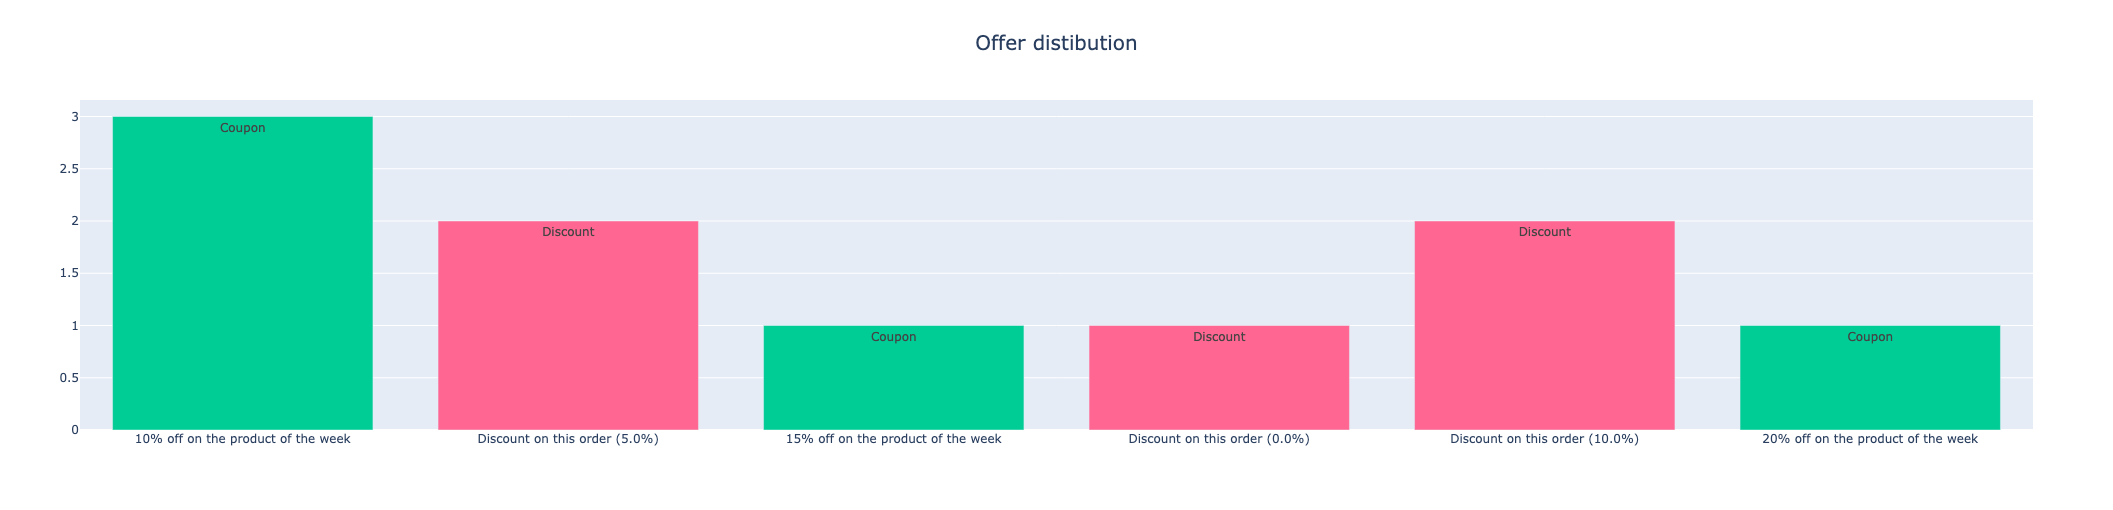

In [12]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=offers_coverage['Order'],
    y=offers_coverage['Count'],
    name='Primary Product',
    marker_color=[px.colors.qualitative.Plotly[6] if type=="Discount" else px.colors.qualitative.Plotly[2] for type in offers_coverage['Type']],
    text=offers_coverage['Type'],
    hovertemplate="<b>Name:</b> %{x}<br><b>Number:</b> %{y}<br><b>Type:</b> %{text}<extra></extra>",
))

fig.update_layout(
  height=max([len(offer_name) for offer_name in offers_coverage['Order']])*15,
  title={'text': "Offer distibution",
          'x':0.5,
          'xanchor': 'center',
          'font_size': 20,
    }
)

fig.show()

### 3.2 Distribution of offers by category <a class="anchor" id="section3_2"></a>

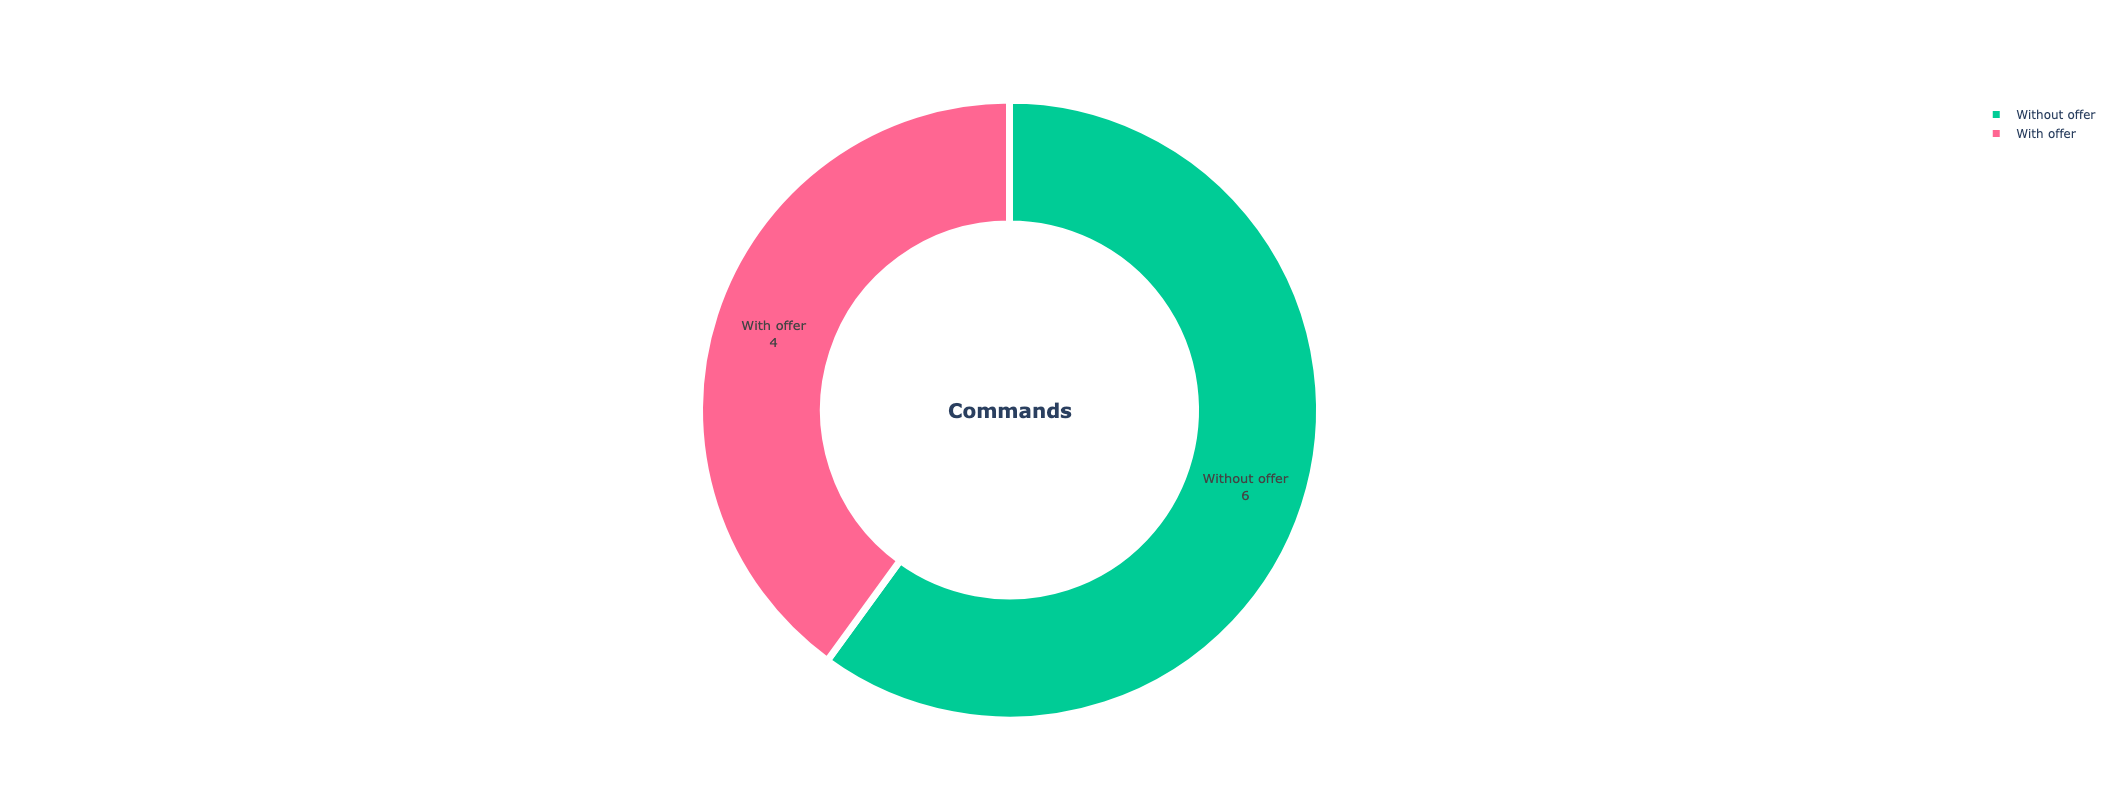

In [13]:
# Here you can define how you want to categorise the offers
# Category 0 exist by default
offers_categories_delimiters = [0, 50, 100, 200, 300, 400, 500, 700, 1000, 2000] # 6 categories: 0 (default), 0-50, 50-100, 100-500, 500-1000, 1000-∞ 

############## setting ################
offers_categories = dict()
last_category_delimiter = offers_categories_delimiters[0]
skip = True
for category_delimiter in offers_categories_delimiters:
    if skip:
        offers_categories[f'no_offer'] = dict(count=0, amount=0)
    else:
        offers_categories[f'amount_range_{last_category_delimiter}-{category_delimiter}'] = dict(count=0, amount=0)
    last_category_delimiter = category_delimiter
    skip = False
offers_categories[f'amount_range_{offers_categories_delimiters[-1]}-∞'] = dict(count=0, amount=0, )


for offer in all_offers:
    last_category_delimiter = offers_categories_delimiters[0]
    for index, category_delimiter in enumerate(offers_categories_delimiters): 
        if offer['value']==0:
            offers_categories[f'no_offer']['count'] += 1
            offers_categories[f'no_offer']['amount'] += offer['value']
            break
        elif(offer['value'] in range(last_category_delimiter, category_delimiter)):
            offers_categories[f'amount_range_{last_category_delimiter}-{category_delimiter}']['count'] += 1
            offers_categories[f'amount_range_{last_category_delimiter}-{category_delimiter}']['amount'] += offer['value']
            break
        elif(offer['value']>=offers_categories_delimiters[-1]):
            offers_categories[f'amount_range_{offers_categories_delimiters[-1]}-∞']['count'] += 1
            offers_categories[f'amount_range_{offers_categories_delimiters[-1]}-∞']['amount'] += offer['value']
            break

        last_category_delimiter = category_delimiter

offers_categories = pd.DataFrame(data={'category':list(offers_categories.keys()), 'count':[content['count'] for content in list(offers_categories.values())], 'amount':[content['amount'] for content in list(offers_categories.values())]})

donut_hole = 0.6

fig = go.Figure(data=[go.Pie(labels=["Without offer", "With offer"], 
                             values=[offers_categories['count'].values[0], offers_categories['count'].values[1:].sum()],
                             text=[0, offers_categories['amount'].sum()],
                             #color_discrete_sequence=px.colors.sequential.Teal,
                             hovertemplate="<b>Name:</b> %{label}<br><b>Number:</b> %{value}<br><b>Amount:</b> %{text}<extra></extra>",
                             hole = donut_hole)])

fig.update_traces(hoverinfo='label', textinfo='label+value', textfont_size=13, textposition="inside",
                  marker=dict(colors=[px.colors.qualitative.Plotly[2], px.colors.qualitative.Plotly[6]], 
                              line=dict(color='#FFFFFF', width=7,)))

fig.update_layout(
  height=800,
  title={'text': "",
          'x':0.5,
          'xanchor': 'center',
          'font_size': 20,
    },
  annotations= [
         {
            "font": {
               "size": 20
            },
            "showarrow": False,
            "text": "<b>Commands</b>",
            "x": 0.5,
            "y": 0.5
         },
  ]
)

fig.show()


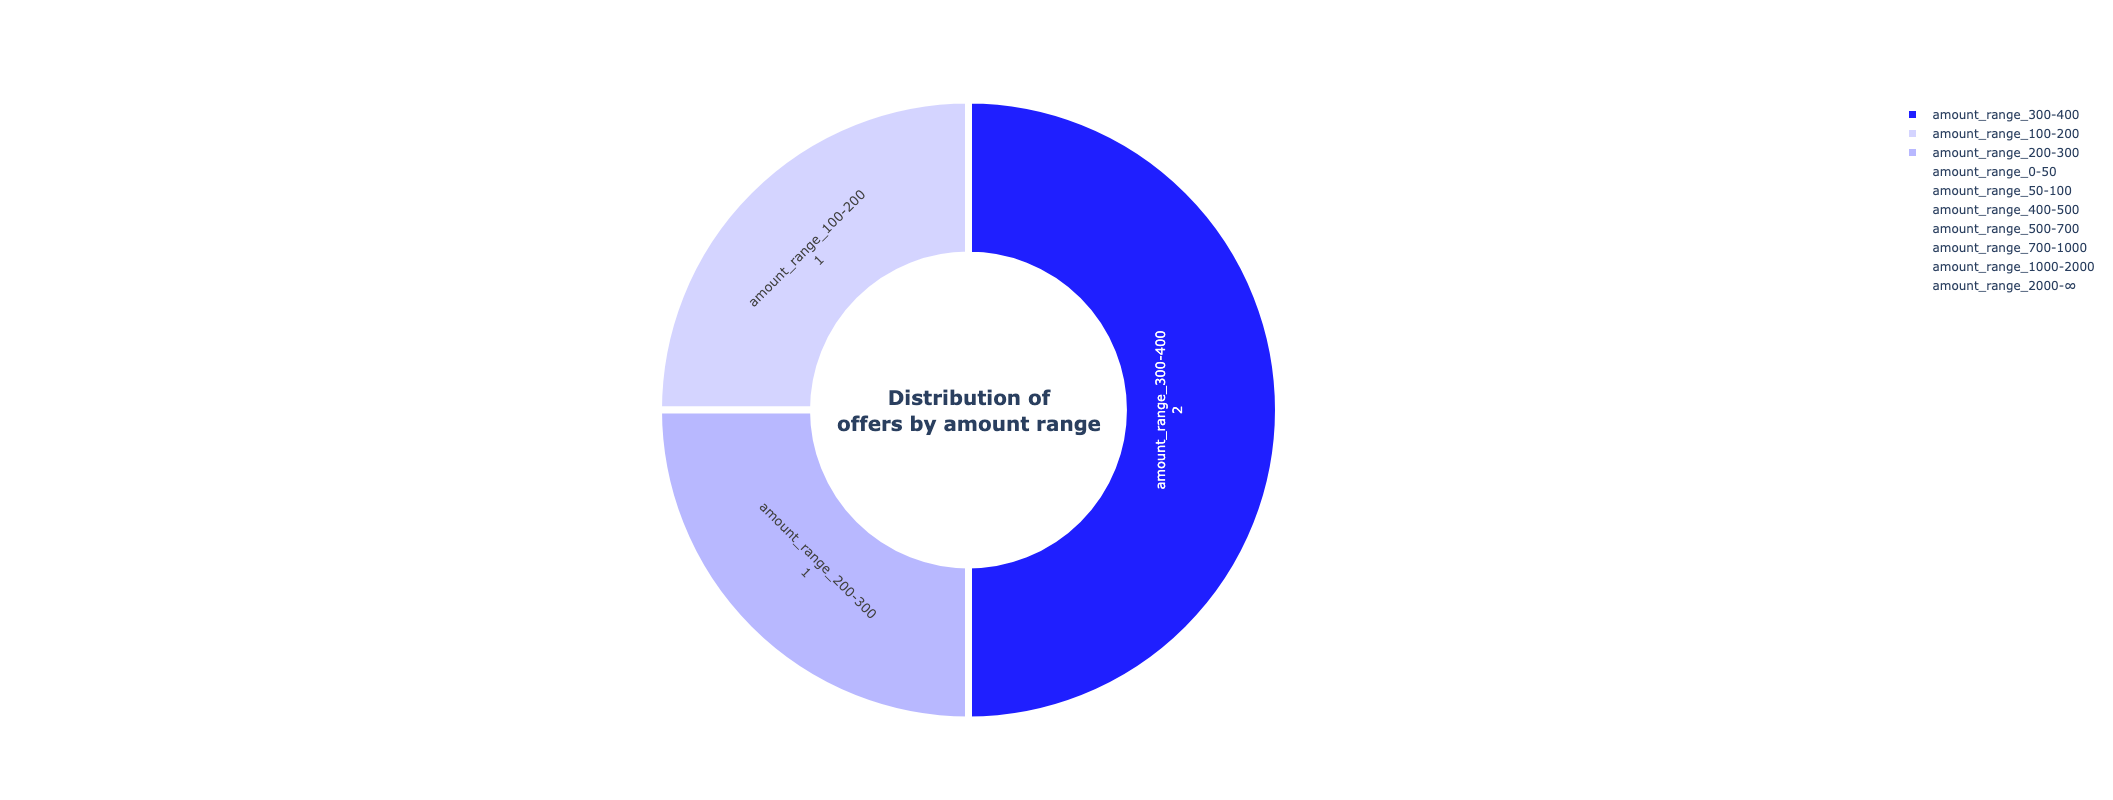

In [14]:
############## graphic ################
donut_hole = 0.5

fig = go.Figure(data=[go.Pie(labels=offers_categories['category'].values[1:], 
                             values=offers_categories['count'].values[1:],
                             text=offers_categories['amount'].values[1:],
                             #color_discrete_sequence=px.colors.sequential.Teal,
                             hovertemplate="<b>Name:</b> %{label}<br><b>Number:</b> %{value}<br><b>Amount:</b> %{text}<extra></extra>",
                             hole = donut_hole)])

fig.update_traces(hoverinfo='label', textinfo='label+value', textfont_size=13, textposition="inside",
                  marker=dict(colors=['rgba(31, 31, 255, {})'.format(amount/max(offers_categories['amount'])) for amount in offers_categories['amount'].values[1:]], 
                              line=dict(color='#FFFFFF', width=7)))

fig.update_layout(
  height=800,
  title={'text': "",
          'x':0.5,
          'xanchor': 'center',
          'font_size': 20,
    },
  annotations= [
         {
            "font": {
               "size": 20
            },
            "showarrow": False,
            "text": "<b>Distribution of<br>offers by amount range</b>",
            "x": 0.5,
            "y": 0.5
         },
  ]
)

fig.show()

### 3.3 Distribution of product references in the orders <a class="anchor" id="section3_3"></a>

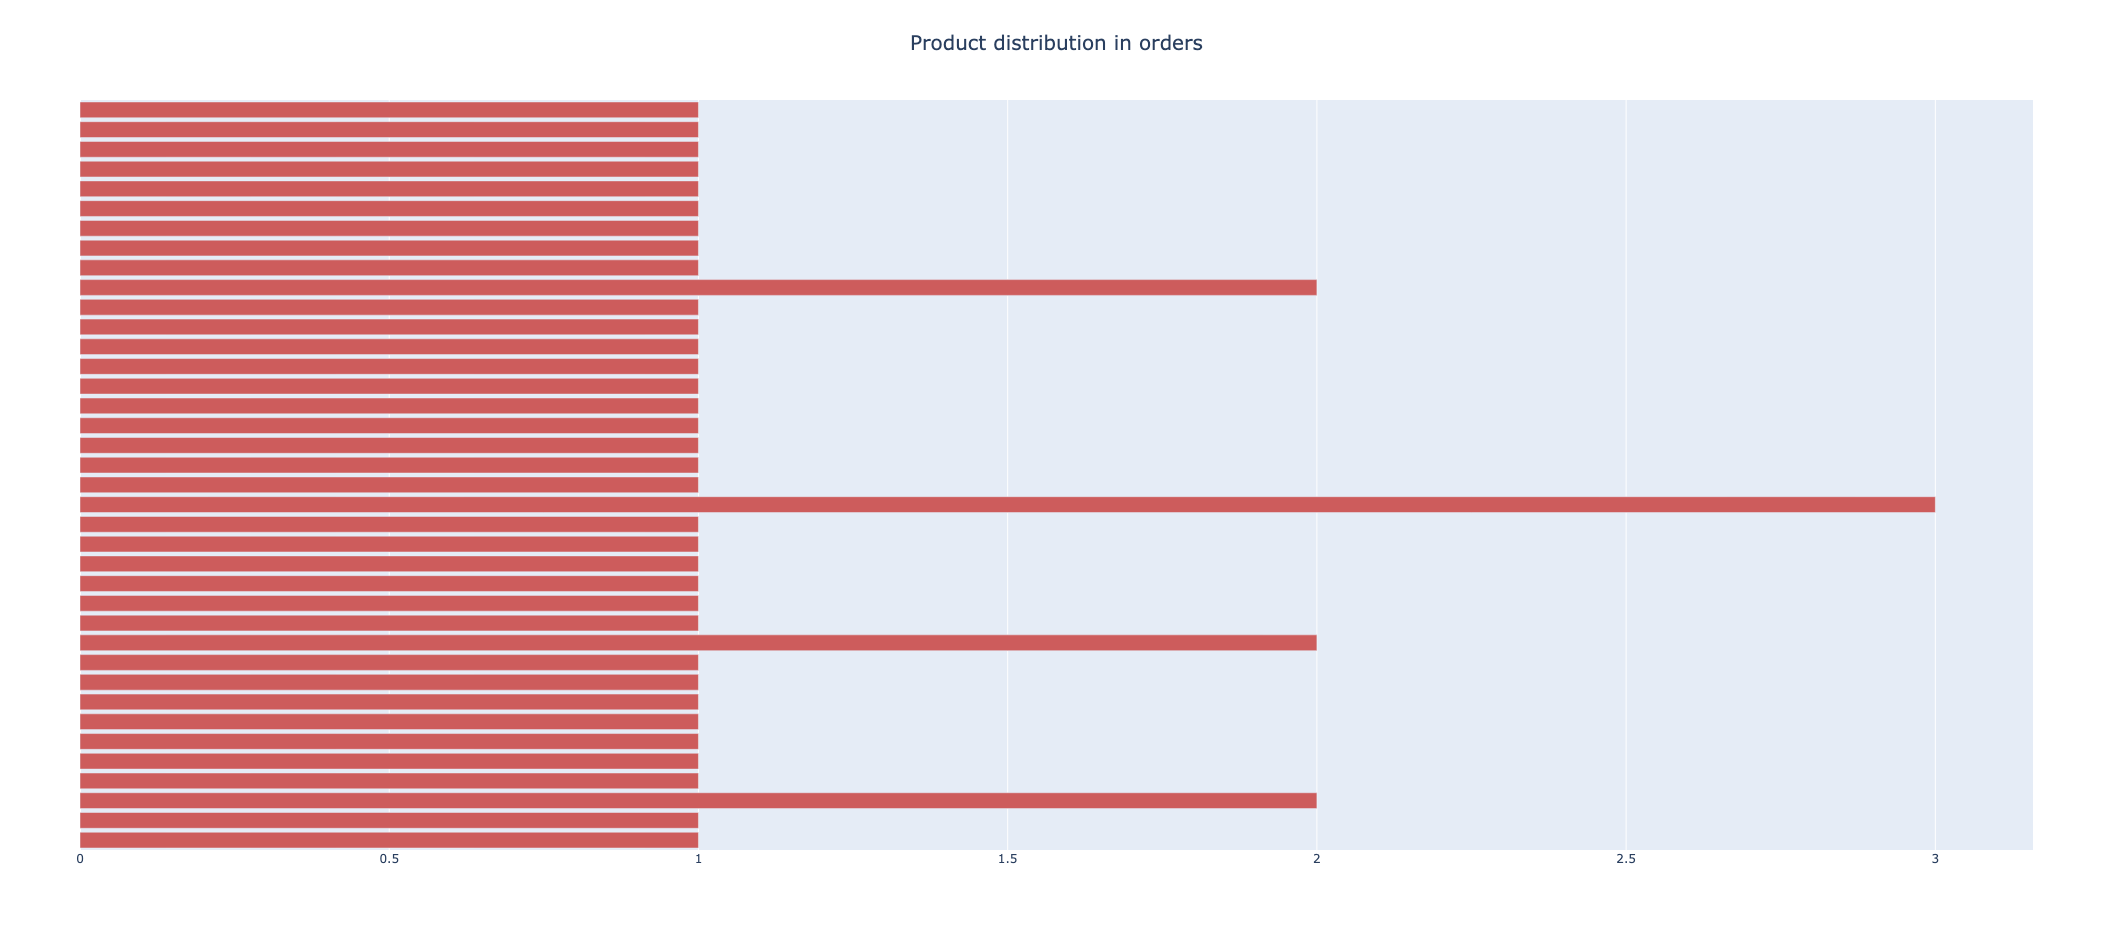

In [15]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=orders_coverage['Count'],
    y=orders_coverage['Order'],
    name='Primary Product',
    marker_color='indianred',
    orientation='h'
))

fig.update_yaxes(visible=False, showticklabels=False)

fig.update_layout(
  height=max([len(order_name) for order_name in orders_coverage['Order']])*10,
  #width=1000, #len(orders_coverage['Order'])*20,
  title={'text': "Product distribution in orders",
          'x':0.5,
          'xanchor': 'center',
          'font_size': 20,
    }
)

fig.show()

## 4 - Go inside the decisions <a class="anchor" id="section4"></a>

We exploit the trace in each of the decision to extract how their outcome was computed. We get the executed and we aggregate them to understand their coverage for this decision set.

This section below allows you to obtain all executed and not executed rules from a specific decision by filling in the decision  Id.  

In [43]:
decisionId = "affba36a-ef3d-4698-a783-ae760315696a"
all_tasks = datasink.query(f'`response.__DecisionID__`=="{decisionId}"')['trace.rootRecord.properties.allTasks'].values
not_executed_tasks = datasink.query(f'`response.__DecisionID__`=="{decisionId}"')['trace.rootRecord.properties.notExecutedTasks'].values
 
executed_tasks = [item for item in all_tasks]
for task in not_executed_tasks:
  if task in all_tasks:
    executed_tasks.remove(task)

print("All tasks : " , datasink.query(f'`response.__DecisionID__`=="{decisionId}"')['trace.rootRecord.properties.allTasks'])
print("The executed tasks are : " + str(executed_tasks))
#print("The not executed tasks are : " + str(not_executed_tasks))

KeyError: 'trace.rootRecord.properties.allTasks'

In [16]:
def get_rules(record, tasksList=dict()):
    rules = []
    fromTasks = tasksList
    if record["recordType"]=="Rule":
        #delete index in fromTasks
        for index in list(fromTasks.keys())[::-1]:
            if int(index.replace(".", "")) != int(record['recordIndex'].replace(".", "")[0:len(index.replace(".", ""))]): 
                fromTasks.pop(index)

        fromTasks[record['recordIndex']] = record['properties']['name']
        record["from"] = {k:v for k,v in fromTasks.items()}
        rules.append(record)
    else:
        if "nestedRecords" in record["properties"]:
            fromTasks[record['recordIndex']] = record['properties']['name'] if 'name' in record['properties'] else record['properties']['mainTask']
            for new_record in record["properties"]["nestedRecords"]:
                rules.extend(get_rules(new_record, fromTasks))
    
    return rules

UNIT TEST SANKEY

In [ ]:
f = open(f"{SIMULATTE_BASE_DIR}/data/ADS/trace-decisionmodel-structure.json", "r")
file = f.read()
trace = json.loads(file)
rules = []

rules = get_rules(trace['rootRecord'])

print(json.dumps(rules[0], indent=4))

{
    "recordType": "Rule",
    "recordIndex": "1.3.1",
    "properties": {
        "actionIndex": "0",
        "name": "Sum",
        "boundObjectsAtStart": {
            "orderAmount": null,
            "order": "java.util.ArrayList@7dcd9bf2"
        },
        "executionDuration": 0,
        "boundObjectsAtEnd": {
            "orderAmount": 3590,
            "order": "java.util.ArrayList@7dcd9bf2"
        }
    },
    "from": {
        "1": "ApplyLoyaltyPolicies-apply-loyalty-policies",
        "1.3": "Order amount",
        "1.3.1": "Sum"
    }
}


GET ALL RULES FROM ALL DECISIONS IN THE DATASET

In [17]:
rules = []
not_executed_rules = []
number_of_rules_per_decision = []

for number_of_decision in range(0,len(outputData)):
    rules.extend(get_rules(outputData[number_of_decision]['trace']['rootRecord']))

#print("RULES : ", rules)

### 4.1 Representing the decision model coverage through a sandkey <a class="anchor" id="section4_1"></a>
We project all decisions into a sandkey diagram. It shows a synthetic view of all executed assets including rules, tasks and decision models.

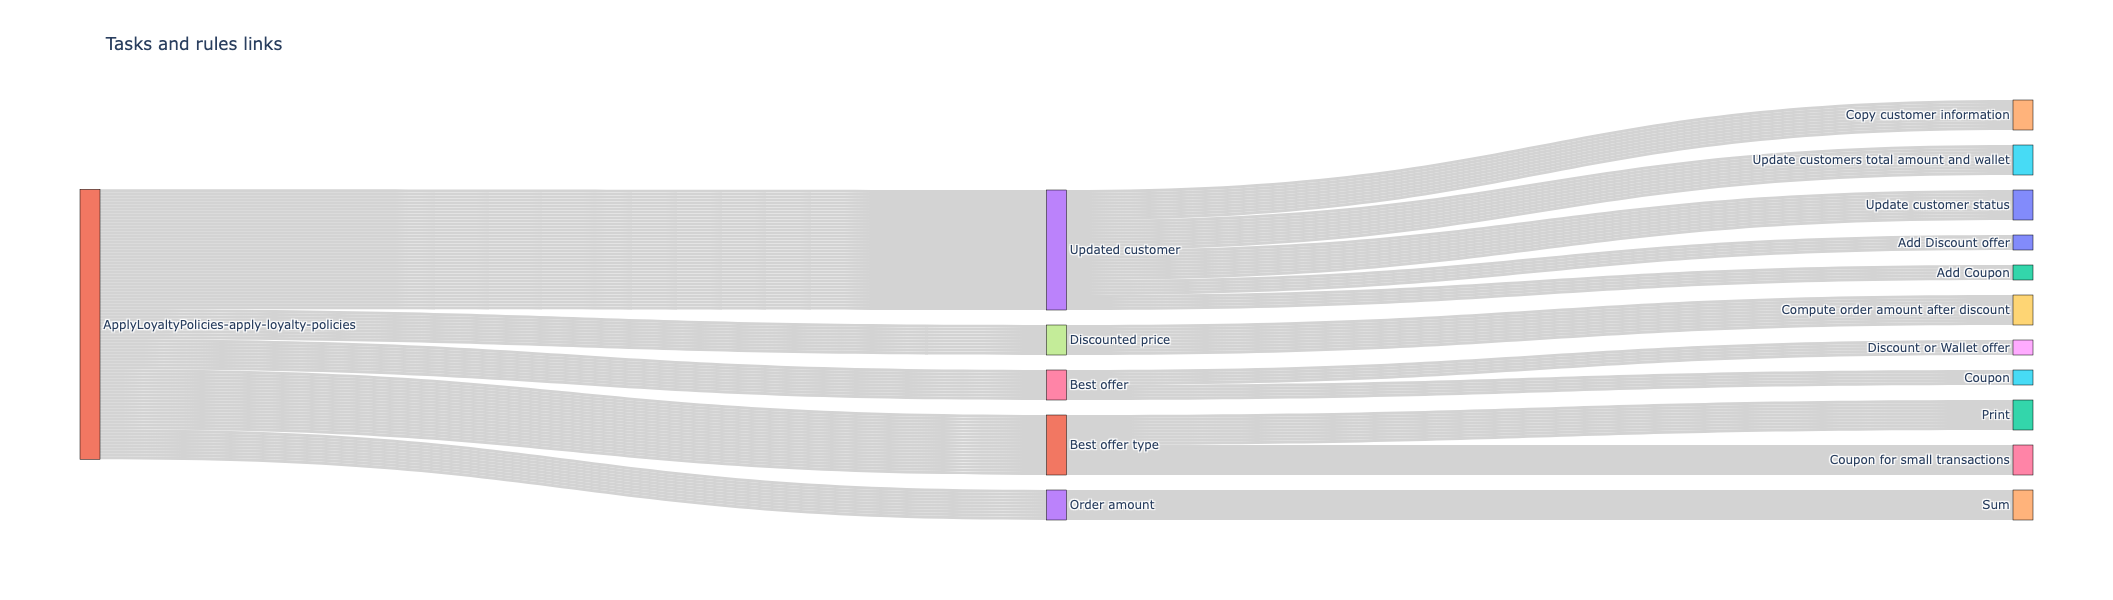

In [18]:
#################### setting #################
sources = []
targets = []
labels = []
values = []

for rule in rules:
    labels.extend(list(rule["from"].values()))

labels = list(set(labels))
for rule in rules:
    for item_source, item_target in zip(list(rule["from"].values())[0::1], list(rule["from"].values())[1::1]):
        sources.append(labels.index(item_source))
        targets.append(labels.index(item_target))
        values.append(1)

    sources.append(labels.index(list(rule["from"].values()).pop()))
    targets.append(labels.index(list(rule["from"].values()).pop()))
    values.append(0)

##################### SANKEY PLOT #################
fig = go.Figure(data=[go.Sankey(
    valueformat = ".0f",

    # Define nodes
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = labels,
      #color = [random.choice(px.colors.qualitative.Plotly) for i in range(0, len(labels))]
    ),

    # Add links
    link = dict(
      source = sources, 
      target = targets,
      value = values,
      label = labels,
      color = "lightgrey"
      #color = [random.choice(px.colors.qualitative.Set3) for i in range(0, len(labels))]
  ))])

fig.update_layout(title_text="Tasks and rules links", height=600, ) #width=2000
fig.show()

### 4.2 Representing the decision model coverage through a sunburst <a class="anchor" id="section4_2"></a>
We project all decisions into a sunburst diagram. It shows a synthetic and interactive view of all executed assets including rules, tasks and decision models.

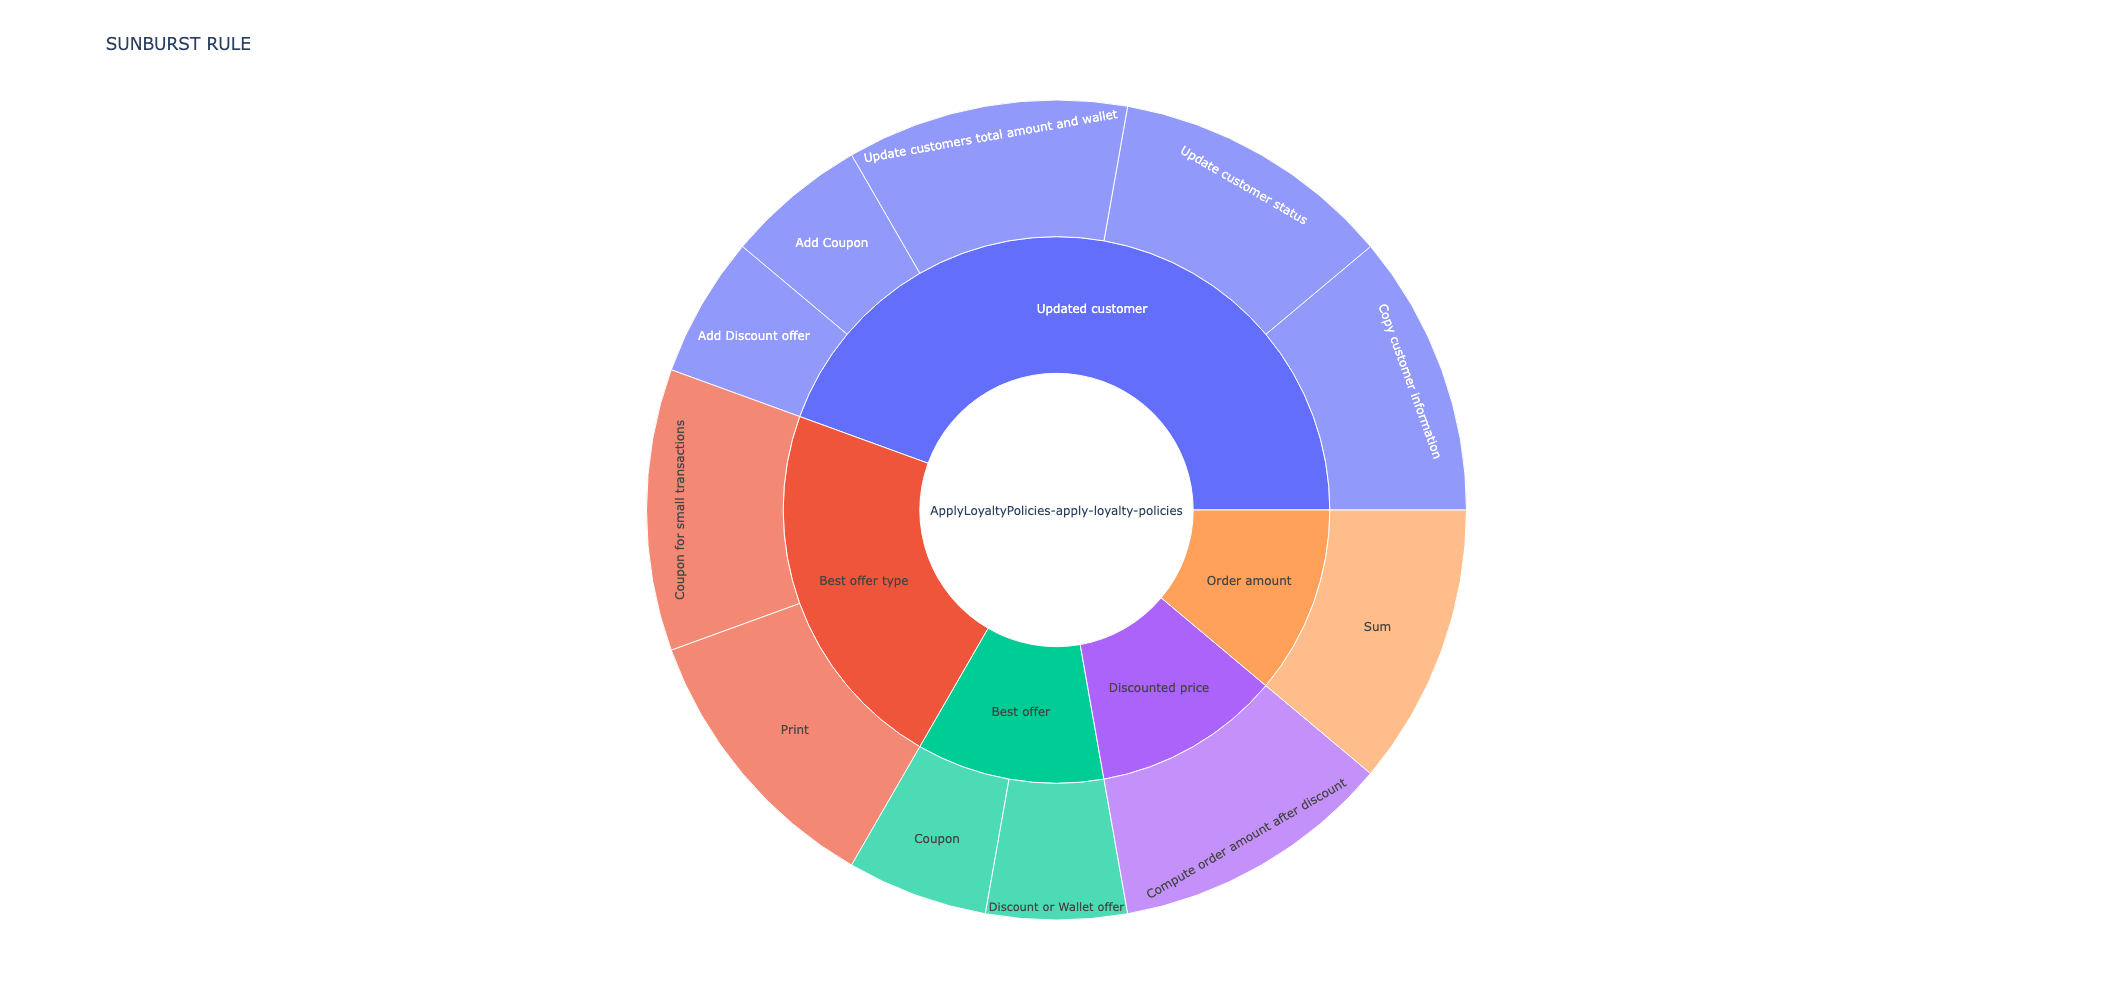

In [19]:
data = []

number_of_columns = 0
for rule in rules:
    number_of_columns = max(number_of_columns, len(rule["from"]))

for rule in rules:
    rule_data = dict()
    keys = list(rule["from"])
    for i in range(0, number_of_columns):
        if i < len(rule["from"]):
            rule_data[f"Column{i}"] = rule["from"][keys[i]]
        else: rule_data[f"Column{i}"] = 'None'

    data.append(rule_data)

df = pd.DataFrame(data)
df = df.groupby(df.columns.tolist()).size().reset_index().rename(columns={0:'Count'})
df = df.replace(['None'],None)
fig = px.sunburst(df, 
                  path=[f"Column{i}" for i in range(0, number_of_columns)], 
                  values="Count",
                  height=1000,
                  title="SUNBURST RULE",
                  maxdepth=5
                  )
fig.show()

### 4.3 Rule coverage <a class="anchor" id="section4_3"></a>
The table below lists the executed rules with their operationnal rate. 100% means that the rule has been executed in all decisions.

In [20]:
rules_counter = dict()
for rule in rules:
    if rule['properties']['name'] in rules_counter:
        rules_counter[rule['properties']['name']] += 1
    else :
        rules_counter[rule['properties']['name']] = 1


#for not_executed_rule in set(not_executed_rules):
#    rules_counter[not_executed_rule] = 0

rules_coverage = pd.DataFrame(rules_counter.items(), columns=['Rule', 'Count'])
rules_coverage['Percentage']= (rules_coverage['Count']*100)/datasink.shape[0]

rules_coverage

,Rule,Count,Percentage
0,Sum,10,100.0
1,Coupon for small transactions,10,100.0
2,Print,10,100.0
3,Coupon,5,50.0
4,Compute order amount after discount,10,100.0
5,Copy customer information,10,100.0
6,Add Coupon,5,50.0
7,Update customers total amount and wallet,10,100.0
8,Update customer status,10,100.0
9,Discount or Wallet offer,5,50.0


### 4.4 Rule coverage bar graph <a class="anchor" id="section4_4"></a>

This view show all executed rules with its execution percentage. The rule coverage empowers business users to check if the statistics of rule execution match their expectations and hypothesis when applied to the applications, and data in general.

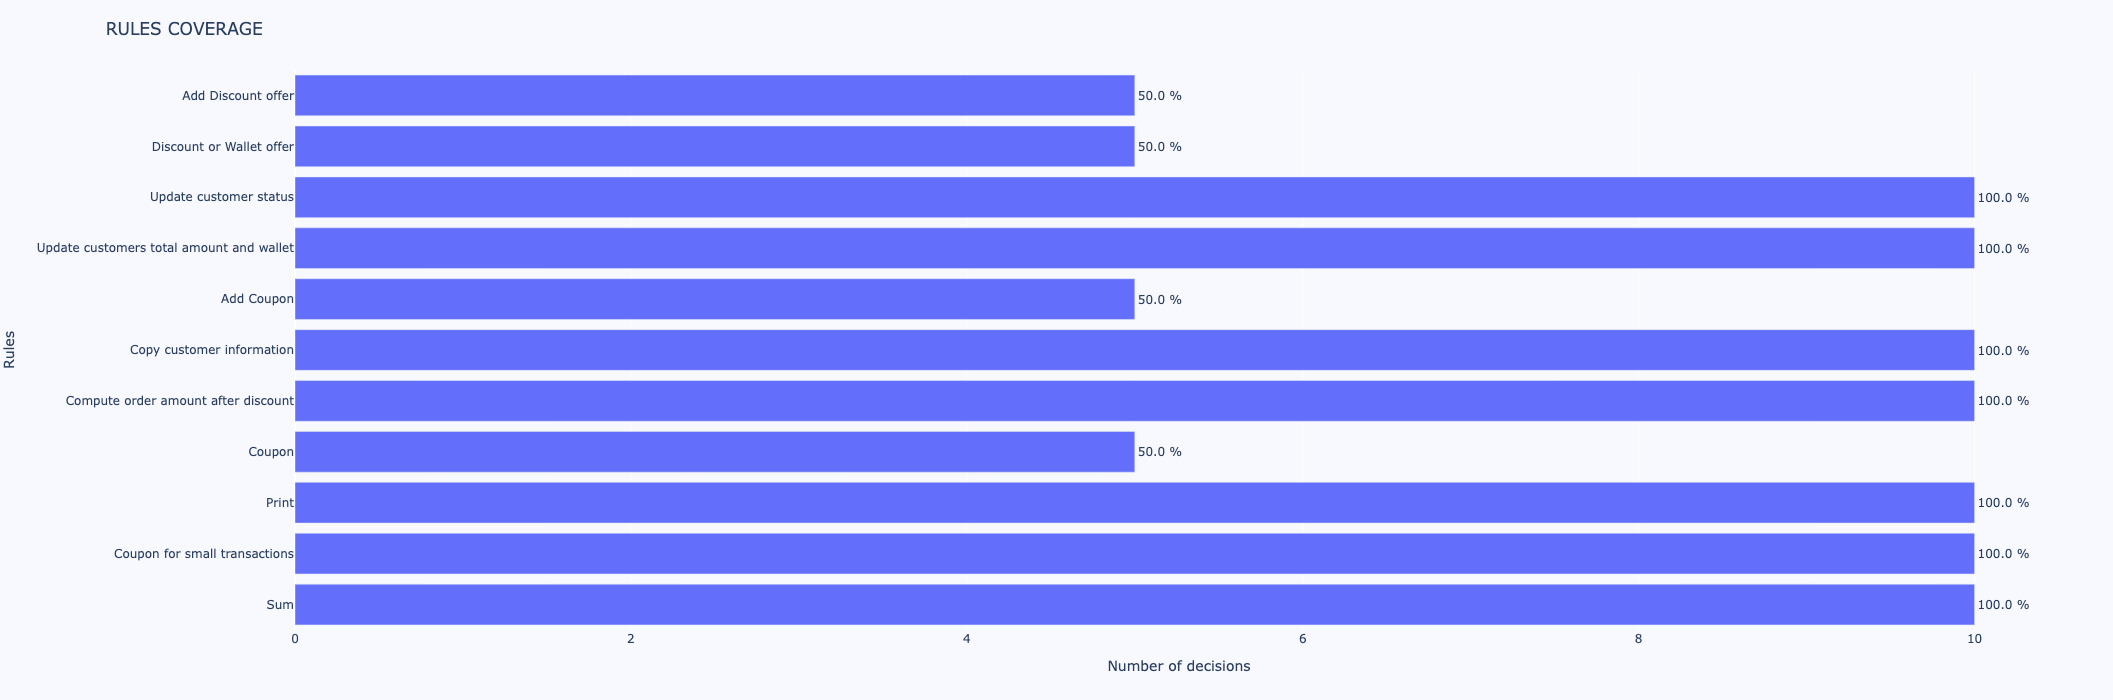

In [21]:
fig = go.Figure(go.Bar(
            x=rules_coverage["Count"],
            y=rules_coverage["Rule"],
            text=[f'{item} %' for item in rules_coverage['Percentage']],
            textposition="outside",
            hovertemplate="<b>%{y}</b><br><b>Count:</b> %{x}<br><b>Percentage:</b> %{text}<extra></extra>",
            orientation='h'))

fig.update_xaxes(title_text='Number of decisions')
fig.update_yaxes(title_text='Rules')

fig.update_layout(
    title='RULES COVERAGE',
    legend=dict(x=0.029, y=1.038, font_size=10),
    margin=dict(l=100, r=50, t=70, b=70),
    height=700,
    paper_bgcolor='rgb(248, 248, 255)',
    plot_bgcolor='rgb(248, 248, 255)',
)
fig.show()

## Conclusion <a class="anchor" id="section5"></a>

This notebook shows a business report to analyze a volume of discount and coupon determinations. It leverages automated decisions performed by IBM Cloud Pak for Business Automation and more precisely Automation Decision Services. This report has been generated by the SimuLatte project that takes care of the simulation and the run of report templates.

Tiémoko Dembélé and Pierre Feillet prepared this report. They are members of IBM France lab and developping actively the SimuLatte project.